In [ ]:
from google.colab import drive
# Mount Google Drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Import necessary libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [ ]:
 # Set the path to the dataset
dataset_path = '/content/gdrive/MyDrive/CV Project/PlantVillage'


In [ ]:
# Function to load and preprocess images
def load_and_preprocess_data(dataset_path):
    classes = os.listdir(dataset_path)
    class_images = {}

    for class_name in classes:
        class_path = os.path.join(dataset_path, class_name)
        images = os.listdir(class_path)
        class_images[class_name] = images

    return class_images
# Load and preprocess data
class_images = load_and_preprocess_data(dataset_path)

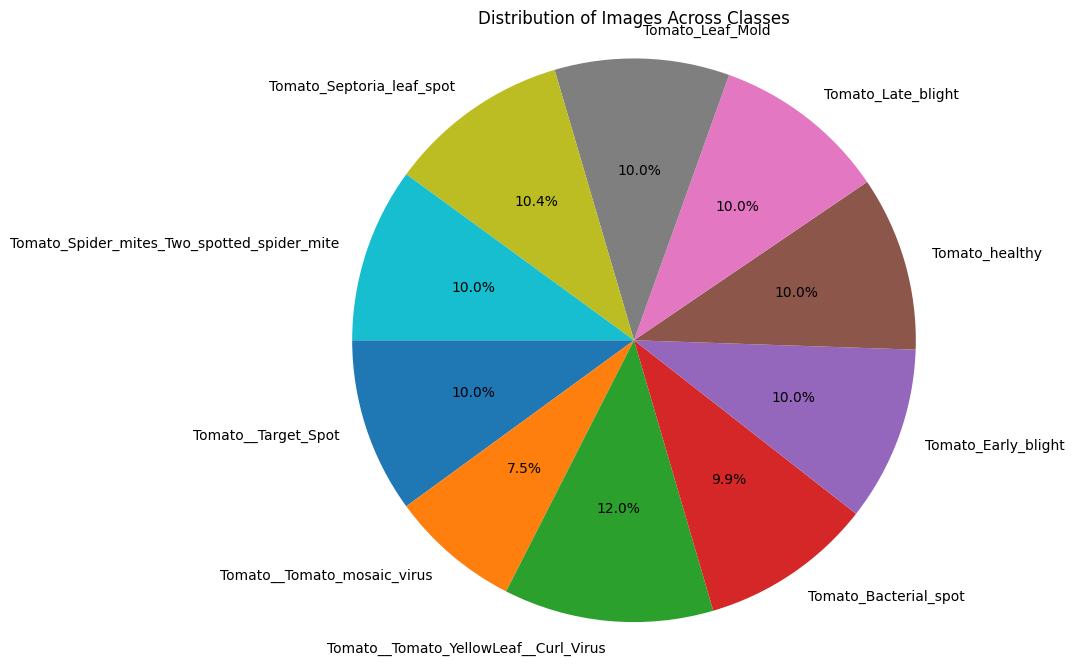

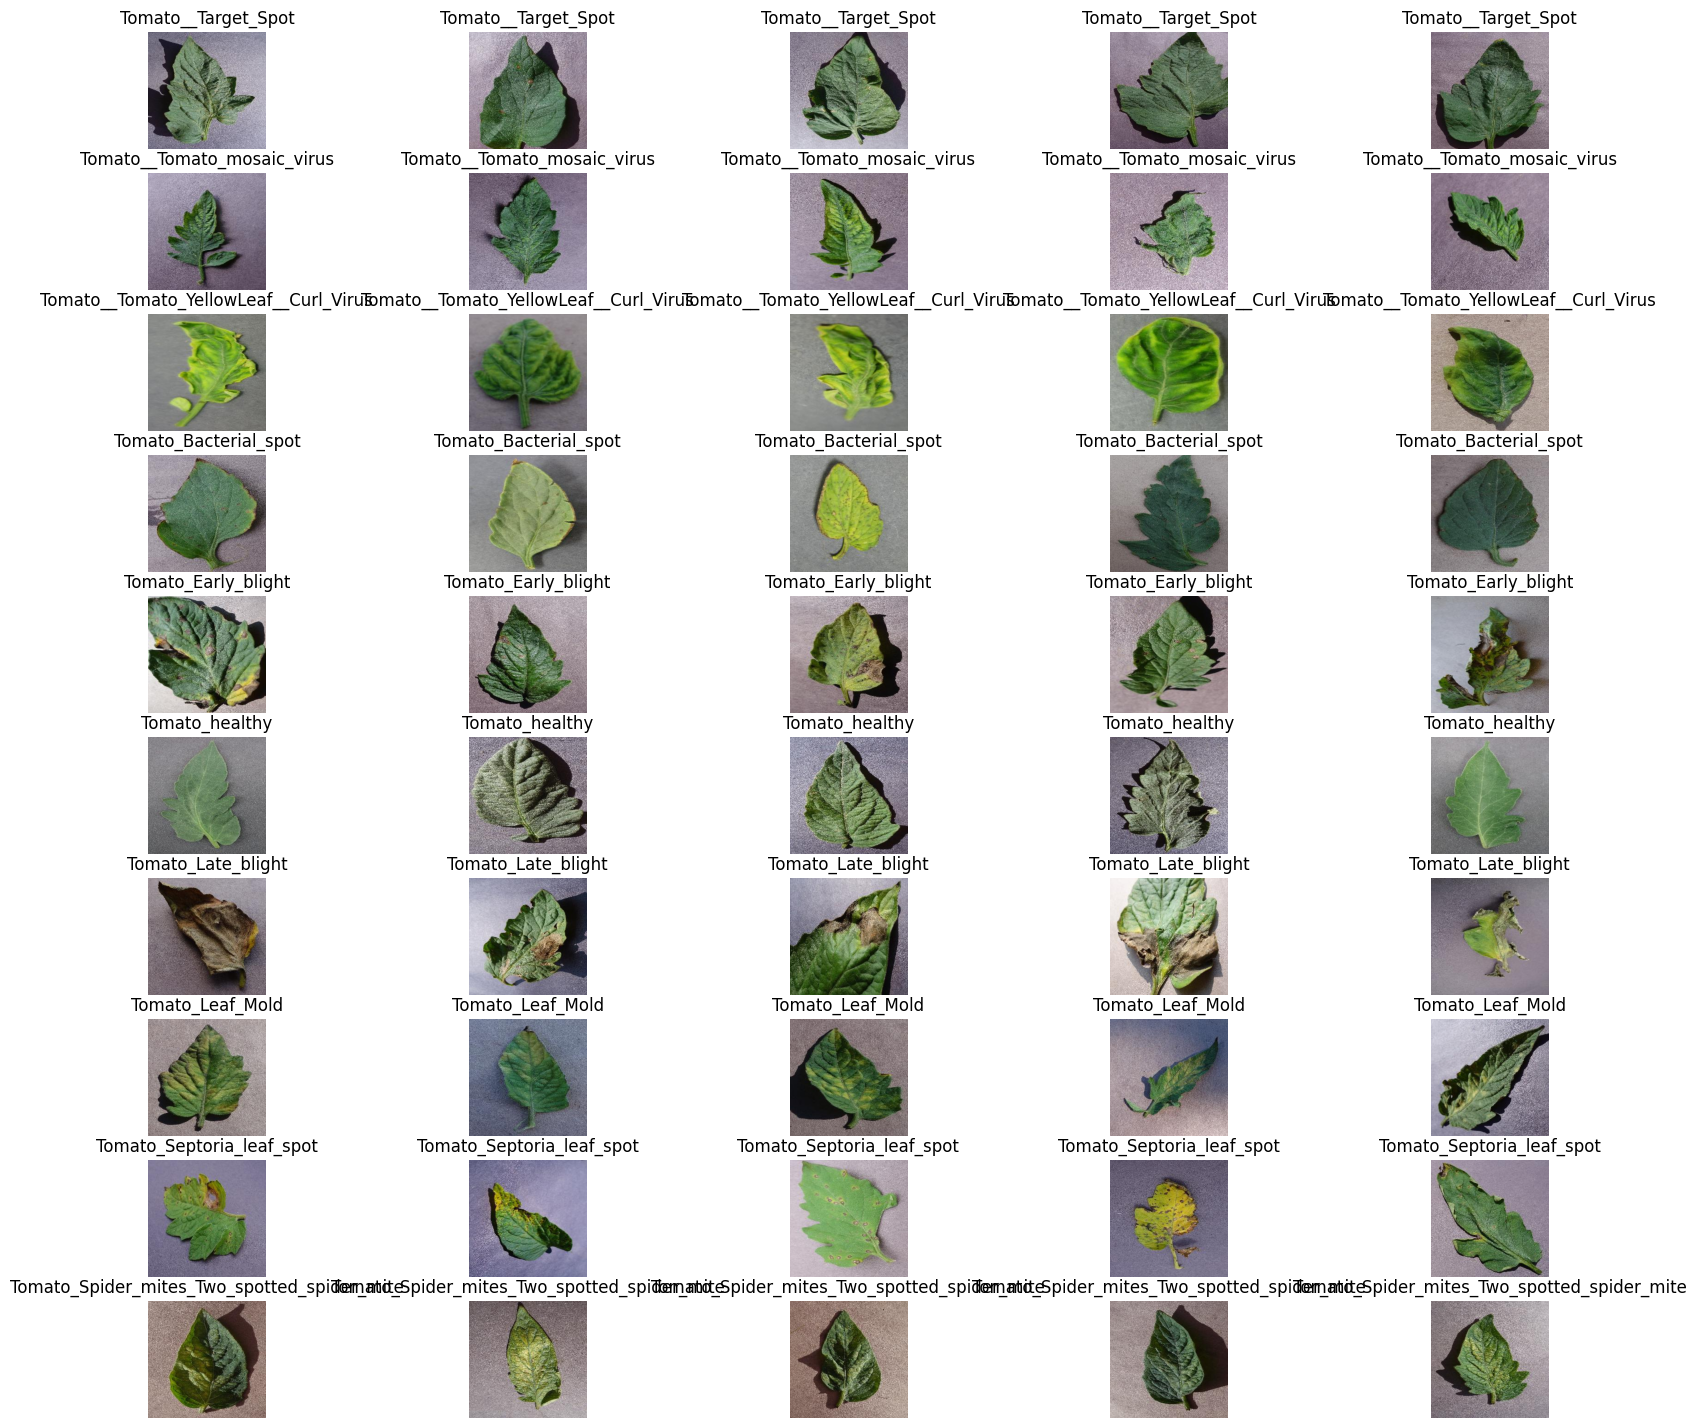

In [ ]:
from matplotlib import pyplot as plt

def plot_dataset_statistics(class_images):
  """
  Plots statistics about the dataset, including a pie chart and example images.

  Args:
    class_images: A dictionary mapping class names to lists of image paths.
  """
  num_classes = len(class_images)
  num_images_per_class = [len(images) for images in class_images.values()]

  # Plot pie chart of image distribution across classes
  plt.figure(figsize=(8, 8))
  plt.pie(num_images_per_class, labels=class_images.keys(), autopct='%1.1f%%', startangle=180)
  plt.title('Distribution of Images Across Classes')
  plt.axis('equal')  # Equal aspect ratio ensures a circular pie chart

  plt.show()

  # Plot some example images from each class
  fig, axes = plt.subplots(nrows=len(class_images), ncols=5, figsize=(20, 18))

  for i, (class_name, images) in enumerate(class_images.items()):
    for j in range(5):
      image_path = os.path.join(dataset_path, class_name, images[j])
      img = cv2.imread(image_path)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

      axes[i, j].imshow(img)
      axes[i, j].set_title(class_name)
      axes[i, j].axis('off')

  plt.show()

# Call the function to plot statistics and show some images
plot_dataset_statistics(class_images)

In [ ]:
# Image data augmentation using Keras ImageDataGenerator
def augment_images(class_images, dataset_path, output_path, augmentations_per_image=5):
    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    for class_name, images in class_images.items():
        class_path = os.path.join(output_path, class_name)
        os.makedirs(class_path, exist_ok=True)

        for image_name in images:
            image_path = os.path.join(dataset_path, class_name, image_name)
            img = cv2.imread(image_path)

            # Check if the image is successfully read
            if img is None:
                print(f"Error reading image: {image_path}")
                continue

            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img.reshape((1,) + img.shape)

            i = 0
            for batch in datagen.flow(img, batch_size=1, save_to_dir=class_path, save_prefix='aug', save_format='jpg'):
                i += 1
                if i >= augmentations_per_image:
                    break



In [ ]:
# Set the path to save augmented images
output_path = '/content/gdrive/MyDrive/CV Project/Pre-img'

In [ ]:
# Call the function to augment images
augment_images(class_images, dataset_path, output_path)


In [ ]:
def plot_dataset_statistics1(class_images):
    num_classes = len(class_images)
    num_images_per_class = [len(images) for images in class_images.values()]

    # Plot pie chart of image distribution across classes
    plt.figure(figsize=(8, 8))
    plt.pie(num_images_per_class, labels=class_images.keys(), autopct='%1.1f%%', startangle=180)
    plt.title('Distribution of Images Across Classes')
    plt.axis('equal')  # Ensure the pie chart is circular

    plt.show()


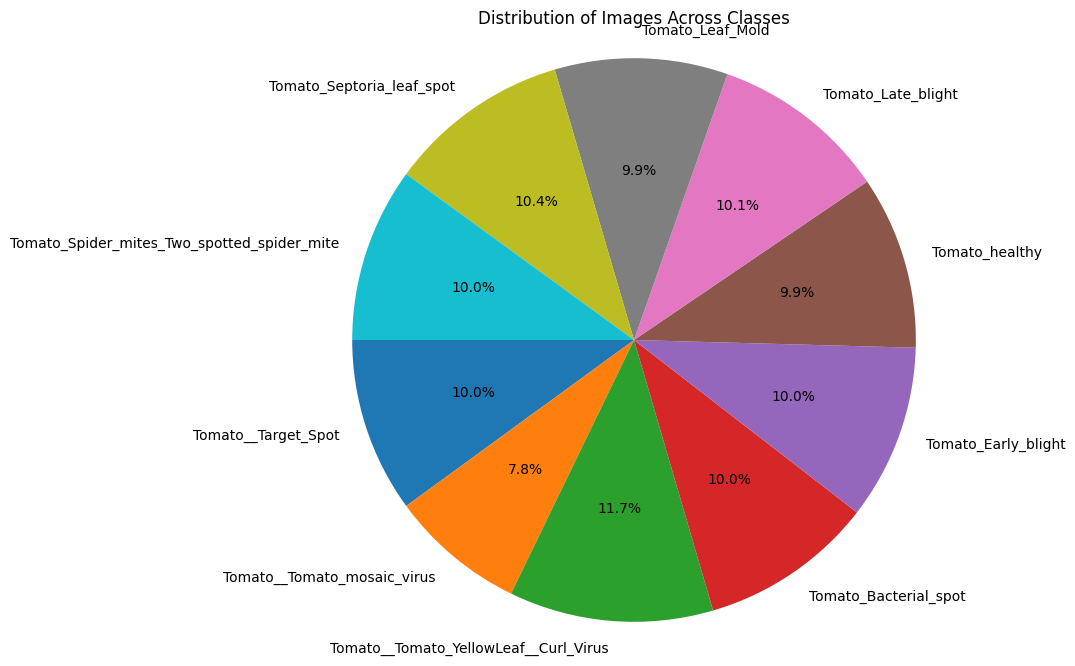

In [ ]:
# Plot some augmented images
augmented_images = load_and_preprocess_data(output_path)
plot_dataset_statistics1(augmented_images)

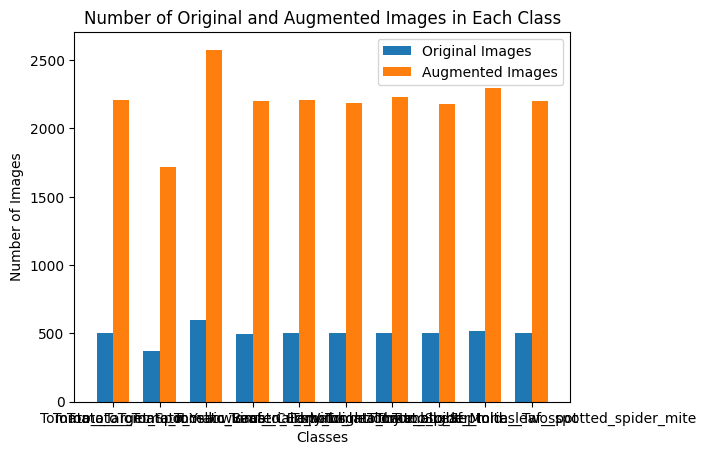

In [ ]:
def plot_dataset_statistics2(class_images, augmented_images):
    num_classes = len(class_images)

    # Count original images per class
    num_original_images = [len(images) for images in class_images.values()]

    # Count augmented images per class
    num_augmented_images = [len(images) for images in augmented_images.values()]

    # Plot bar chart of image counts for original and augmented classes
    bar_width = 0.35
    indices = range(num_classes)

    plt.bar(indices, num_original_images, width=bar_width, label='Original Images')
    plt.bar([i + bar_width for i in indices], num_augmented_images, width=bar_width, label='Augmented Images')

    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.title('Number of Original and Augmented Images in Each Class')
    plt.xticks([i + bar_width / 2 for i in indices], class_images.keys())
    plt.legend()

    plt.show()

class_images = load_and_preprocess_data(dataset_path)
plot_dataset_statistics2(class_images,augmented_images)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split

In [ ]:
# Merge original and augmented images into a single dataset
all_images = {class_name: class_images[class_name] + augmented_images[class_name] for class_name in class_images}


In [ ]:

# Split the dataset into training and validation sets
train_images, val_images, train_labels, val_labels = [], [], [], []
for class_name, images in all_images.items():
    train_split, val_split = train_test_split(images, test_size=0.2, random_state=42)

    train_images.extend(train_split)
    val_images.extend(val_split)
    train_labels.extend([class_name] * len(train_split))
    val_labels.extend([class_name] * len(val_split))

# Define constants
img_size = (128, 128)
input_shape = (img_size[0], img_size[1], 3)
batch_size = 32
epochs = 10

In [ ]:
# Define the CNN model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(all_images), activation='softmax'))

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Image data augmentation for training
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

In [ ]:
# Load and preprocess training images
train_generator = train_datagen.flow_from_directory(
    dataset_path,  # Use the path to the directory containing your images
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size
)

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# Save the trained model in .h5 format
model.save('PlantVillage_model.h5')
print("Model saved as PlantVillage_model.h5")